## Import necessary libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import time

from math import sqrt
from numpy import loadtxt
from itertools import product
from tqdm import tqdm
from sklearn import preprocessing
from xgboost import plot_tree
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 60)

# Part2
## Set up some global vars 

In [30]:

# Set seeds and options
np.random.seed(10)
pd.set_option('display.max_rows', 231)
pd.set_option('display.max_columns', 100)

    # Feature engineering list
new_features = []
enable_feature_idea = [True, True, True, True, True, True, True, True, True, True]

    # Some parameters(maybe add more periods, score will be better) [1,2,3,12]
lookback_range = [1,2,3]

tqdm.pandas()


## Load data

In [31]:
test_dataset = loadtxt('D:\\all\\test.csv', delimiter="," ,skiprows=1, usecols = (1,2), dtype=int)
testset = pd.DataFrame(test_dataset, columns = ['shop_id', 'item_id'])

trainset = pd.read_csv('trainset_with_grid.csv')
items = pd.read_csv('D:\\all\\items.csv')
#shops = pd.read_csv('data/shops.csv')


    # Only use more recent data
start_month = 0
end_month = 33
#trainset = trainset[[ 'item_id', 'item_category_id', 'date_block_num', 'item_price', 'item_cnt_month']]
trainset = trainset[[ 'shop_id', 'item_id', 'item_category_id', 'date_block_num',  'item_cnt_month']]
trainset = trainset[(trainset.date_block_num >= start_month) & (trainset.date_block_num <= end_month)]


test_dataset = loadtxt('D:\\all\\test.csv', delimiter="," ,skiprows=1, usecols = (1,2), dtype=int)
testset = pd.DataFrame(test_dataset, columns = ['shop_id', 'item_id'])


    # Get item category id into test_df
testset = testset.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')
testset['date_block_num'] = 34
    # Make testset contains same column as trainset so we can concatenate them row-wise
testset['item_cnt_month'] = -1

train_test_set = pd.concat([trainset, testset], axis = 0) 
train_test_set.head()


,shop_id,item_id,item_category_id,date_block_num,item_cnt_month
0,59,22154,37,0,1.0
1,25,22154,37,0,5.0
2,24,22154,37,0,1.0
3,19,22154,37,0,0.0
4,22,22154,37,0,0.0


## Fix category

In [32]:
item_categories=pd.read_csv('D:\\all\\item_categories.csv')
l_cat = list(item_categories.item_category_name)
l_cat[0] = 'PC Headsets'
for i in range (1,8):
    l_cat[i]="Access"
l_cat[8] = 'Tickets'
l_cat[9] = 'Delivery'
for ind in range(10,18):
    l_cat[ind] = 'Consoles'
for ind in range(18,25):
    l_cat[ind] = 'Console Games'
l_cat[25] = 'Accessories for games'
for ind in range(26,28):
    l_cat[ind] = 'phone games'
for ind in range(28,32):
    l_cat[ind] = 'CD games'
for ind in range(32,37):
    l_cat[ind] = 'Card'
for ind in range(37,43):
    l_cat[ind] = 'Movie'
for ind in range(43,55):
    l_cat[ind] = 'Books'
for ind in range(55,61):
    l_cat[ind] = 'Music'
for ind in range(61,73):
    l_cat[ind] = 'Gifts'
for ind in range(73,79):
    l_cat[ind] = 'Soft'
for ind in range(79,81):
    l_cat[ind] = 'Office'
for ind in range(81,83):
    l_cat[ind] = 'Clean'
l_cat[83] = 'Elements of a food'
lb = preprocessing.LabelEncoder()
item_categories['item_category_id_fix'] = lb.fit_transform(l_cat)
item_categories['item_category_name_fix'] = l_cat
item_categories.head()

,item_category_name,item_category_id,item_category_id_fix,item_category_name_fix
0,PC - Гарнитуры/Наушники,0,14,PC Headsets
1,Аксессуары - PS2,1,0,Access
2,Аксессуары - PS3,2,0,Access
3,Аксессуары - PS4,3,0,Access
4,Аксессуары - PSP,4,0,Access


In [33]:
train_test_set = train_test_set.merge(item_categories[['item_category_id', 'item_category_id_fix']], on = 'item_category_id', how = 'left')
_ = train_test_set.drop(['item_category_id'],axis=1, inplace=True)
train_test_set.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)

_ = item_categories.drop(['item_category_id'],axis=1, inplace=True)
_ = item_categories.drop(['item_category_name'],axis=1, inplace=True)


item_categories.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)
item_categories.rename(columns = {'item_category_name_fix':'item_category_name'}, inplace = True)
item_categories = item_categories.drop_duplicates()
item_categories.index = np.arange(0, len(item_categories))
#train_test_set=train_test_set.drop("item_price", axis=1)
train_test_set.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id
0,59,22154,0,1.0,11
1,25,22154,0,5.0,11
2,24,22154,0,1.0,11
3,19,22154,0,0.0,11
4,22,22154,0,0.0,11


# Idea 0: Add previous shop/item sales as feature (Lag feature)

In [34]:

if enable_feature_idea[0]:
    for diff in tqdm(lookback_range):
        feature_name = 'prev_shopitem_sales_' + str(diff)
        trainset2 = train_test_set.copy()
        trainset2.loc[:, 'date_block_num'] += diff
        trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
        new_features.append(feature_name)
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.37s/it]


,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3
0,59,22154,0,1.0,11,0.0,0.0,0.0
1,25,22154,0,5.0,11,0.0,0.0,0.0
2,24,22154,0,1.0,11,0.0,0.0,0.0


# Idea 1: Add previous average item sales per period as feature 

In [35]:
if enable_feature_idea[1]:
    groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_item_sales_' + str(diff)
        result = groups.agg({'item_cnt_month':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
        new_features.append(feature_name)        
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.51s/it]


,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3
0,59,22154,0,1.0,11,0.0,0.0,0.0,0.0,0.0,0.0
1,25,22154,0,5.0,11,0.0,0.0,0.0,0.0,0.0,0.0
2,24,22154,0,1.0,11,0.0,0.0,0.0,0.0,0.0,0.0


# Idea 2: Add previous shop/item price as feature (Lag feature)

In [13]:

if enable_feature_idea[3]:
    groups = train_test_set.groupby(by = ['shop_id', 'item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_shopitem_price_' + str(diff)
        result = groups.agg({'item_price':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_price': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(result, on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name]
        new_features.append(feature_name)        
train_test_set.head(3)


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:03<00:00,  7.74s/it]


,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_category_id,city_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_shopitem_sales_7,prev_shopitem_sales_8,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,prev_item_sales_7,prev_item_sales_8,prev_shopitem_price_1,prev_shopitem_price_2,prev_shopitem_price_3,prev_shopitem_price_4,prev_shopitem_price_5,prev_shopitem_price_6,prev_shopitem_price_7,prev_shopitem_price_8
0,0,1.0,22154,999.0,59,11,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,5.0,22154,999.0,25,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1.0,22154,999.0,24,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Idea 3: Add previous item price as feature (Lag feature)

In [14]:

if enable_feature_idea[3]:
    groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
    for diff in tqdm(lookback_range):
        feature_name = 'prev_item_price_' + str(diff)
        result = groups.agg({'item_price':'mean'})
        result = result.reset_index()
        result.loc[:, 'date_block_num'] += diff
        result.rename(columns={'item_price': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name]
        new_features.append(feature_name)        
train_test_set.head(3)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:29<00:00,  3.65s/it]


,date_block_num,item_cnt_month,item_id,item_price,shop_id,item_category_id,city_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_shopitem_sales_4,prev_shopitem_sales_5,prev_shopitem_sales_6,prev_shopitem_sales_7,prev_shopitem_sales_8,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,prev_item_sales_4,prev_item_sales_5,prev_item_sales_6,prev_item_sales_7,prev_item_sales_8,prev_shopitem_price_1,prev_shopitem_price_2,prev_shopitem_price_3,prev_shopitem_price_4,prev_shopitem_price_5,prev_shopitem_price_6,prev_shopitem_price_7,prev_shopitem_price_8,prev_item_price_1,prev_item_price_2,prev_item_price_3,prev_item_price_4,prev_item_price_5,prev_item_price_6,prev_item_price_7,prev_item_price_8
0,0,1.0,22154,999.0,59,11,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,5.0,22154,999.0,25,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1.0,22154,999.0,24,11,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Idea 4: Mean encodings for shop/item pairs

In [36]:
def create_mean_encodings(train_test_set, categorical_var_list, target):
    feature_name = "_".join(categorical_var_list) + "_" + target + "_mean"

    df = train_test_set.copy()
    df1 = df[df.date_block_num <= 32]
    df2 = df[df.date_block_num <= 33]
    df3 = df[df.date_block_num == 34]

    # Extract mean encodings using training data(here we don't use month 33 to avoid data leak on validation)
    # If I try to extract mean encodings from all months, then val rmse decreases a tiny bit, but test rmse would increase by 4%
    # So this is important
    mean_32 = df1[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
    mean_32 = mean_32.rename(columns={target:feature_name})

    # Extract mean encodings using all data, this will be applied to test data
    mean_33 = df2[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
    mean_33 = mean_33.rename(columns={target:feature_name})

    # Apply mean encodings
    df2 = df2.merge(mean_32, on = categorical_var_list, how = 'left')
    df3 = df3.merge(mean_33, on = categorical_var_list, how = 'left')

    # Concatenate
    train_test_set = pd.concat([df2, df3], axis = 0)
    new_features.append(feature_name)
    return train_test_set

In [37]:
categorical_var_list=['shop_id', 'item_id']
target='item_cnt_month'
feature_name = "_".join(categorical_var_list) + "_" + target + "_mean"

df = train_test_set.copy()
df1 = df[df.date_block_num <= 32]
df2 = df[df.date_block_num <= 33]
df3 = df[df.date_block_num == 34]
mean_32 = df1[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
mean_32 = mean_32.rename(columns={target:feature_name})

 # Extract mean encodings using all data, this will be applied to test data
mean_33 = df2[categorical_var_list + [target]].groupby(categorical_var_list, as_index=False)[[target]].mean()
mean_33 = mean_33.rename(columns={target:feature_name})
df2 = df2.merge(mean_32, on = categorical_var_list, how = 'left')
df3 = df3.merge(mean_33, on = categorical_var_list, how = 'left')
train_test_set = pd.concat([df2, df3], axis = 0)
new_features.append(feature_name)
train_test_set.head(3)


,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,shop_id_item_id_item_cnt_month_mean
0,59,22154,0,1.0,11,0.0,0.0,0.0,0.0,0.0,0.0,0.090909
1,25,22154,0,5.0,11,0.0,0.0,0.0,0.0,0.0,0.0,0.636364
2,24,22154,0,1.0,11,0.0,0.0,0.0,0.0,0.0,0.0,0.090909


In [12]:
new_features.pop()

'shop_id_item_id_item_cnt_month_mean'

In [13]:
new_features.remove('shop_id_item_id_item_cnt_month_mean')

In [11]:
new_features

['prev_shopitem_sales_1',
 'prev_shopitem_sales_2',
 'prev_shopitem_sales_3',
 'prev_item_sales_1',
 'prev_item_sales_2',
 'prev_item_sales_3',
 'shop_id_item_id_item_cnt_month_mean',
 'shop_id_item_id_item_cnt_month_mean']

# Idea 5: Mean encodings for item (Mean encoding, doesnt work for me)

In [38]:

train_test_set = create_mean_encodings(train_test_set, ['item_id'], 'item_cnt_month')
train_test_set.head(3)

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,prev_shopitem_sales_1,prev_shopitem_sales_2,prev_shopitem_sales_3,prev_item_sales_1,prev_item_sales_2,prev_item_sales_3,shop_id_item_id_item_cnt_month_mean,item_id_item_cnt_month_mean
0,59,22154,0,1.0,11,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.104623
1,25,22154,0,5.0,11,0.0,0.0,0.0,0.0,0.0,0.0,0.636364,0.104623
2,24,22154,0,1.0,11,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.104623


# Idea 6: Number of month from last sale of shop/item (Use info from past)

In [ ]:
def create_last_sale_shop_item(row):
    for diff in range(1,33+1):
        feature_name = '_prev_shopitem_sales_' + str(diff)
        if row[feature_name] != 0.0:
            return diff
    return np.nan


lookback_range = list(range(1, 33 + 1))
if enable_feature_idea[6]:
    for diff in tqdm(lookback_range):
        feature_name = '_prev_shopitem_sales_' + str(diff)
        trainset2 = train_test_set.copy()
        trainset2.loc[:, 'date_block_num'] += diff
        trainset2.rename(columns={'item_cnt_month': feature_name}, inplace=True)
        train_test_set = train_test_set.merge(trainset2[['shop_id', 'item_id', 'date_block_num', feature_name]], on = ['shop_id', 'item_id', 'date_block_num'], how = 'left')
        train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
            #new_features.append(feature_name)

train_test_set.loc[:, 'last_sale_shop_item'] = train_test_set.progress_apply (lambda row: create_last_sale_shop_item(row),axis=1)
new_features.append('last_sale_shop_item')

 73%|███████████████████████████████████████████████████████████▋                      | 24/33 [11:21<09:57, 66.40s/it]

# Idea 7: Number of month from last sale of item(Use info from past)

In [ ]:
def create_last_sale_item(row):
    for diff in range(1,33+1):
        feature_name = '_prev_item_sales_' + str(diff)
        if row[feature_name] != 0.0:
            return diff
    return np.nan
if kernel_with_output:
    lookback_range = list(range(1, 33 + 1))
    if enable_feature_idea[1]:
        groups = train_test_set.groupby(by = ['item_id', 'date_block_num'])
        for diff in tqdm(lookback_range):
            feature_name = '_prev_item_sales_' + str(diff)
            result = groups.agg({'item_cnt_month':'mean'})
            result = result.reset_index()
            result.loc[:, 'date_block_num'] += diff
            result.rename(columns={'item_cnt_month': feature_name}, inplace=True)
            train_test_set = train_test_set.merge(result, on = ['item_id', 'date_block_num'], how = 'left')
            train_test_set[feature_name] = train_test_set[feature_name].fillna(0)
            new_features.append(feature_name)        
    train_test_set.loc[:, 'last_sale_item'] = train_test_set.progress_apply (lambda row: create_last_sale_item(row),axis=1)

# Cross Validation

In [39]:
results={}
current = time.time()


baseline_features = ['shop_id', 'item_id', 'item_category_id', 'date_block_num'] +  new_features + ['item_cnt_month']

    # Clipping to range 0-20
train_test_set['item_cnt_month'] = train_test_set.item_cnt_month.fillna(0).clip(0,20)

    # train: want rows with date_block_num from 0 to 31
train_time_range_lo = (train_test_set['date_block_num'] >= 0)
train_time_range_hi =  (train_test_set['date_block_num'] <= 32)

    # val: want rows with date_block_num from 22
validation_time =  (train_test_set['date_block_num'] == 33)

    # test: want rows with date_block_num from 34
test_time =  (train_test_set['date_block_num'] == 34)


    # Retrieve rows for train set, val set, test set
cv_trainset = train_test_set[train_time_range_lo & train_time_range_hi]
cv_valset = train_test_set[validation_time]
cv_trainset = cv_trainset[baseline_features]
cv_valset = cv_valset[baseline_features]
testset = train_test_set[test_time]
testset = testset[baseline_features]

    # Prepare numpy arrays for training/val/test
cv_trainset_vals = cv_trainset.values.astype(int)
trainx = cv_trainset_vals[:, 0:len(baseline_features) - 1]
trainy = cv_trainset_vals[:, len(baseline_features) - 1]

cv_valset_vals = cv_valset.values.astype(int)
valx = cv_valset_vals[:, 0:len(baseline_features) - 1]
valy = cv_valset_vals[:, len(baseline_features) - 1]

testset_vals = testset.values.astype(int)
testx = testset_vals[:, 0:len(baseline_features) - 1]

print('Fitting...')
#model = xgb.XGBRegressor(max_depth = 11, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000,
 #                        seed = 1, nthread = -1)
#model.fit(trainx, trainy, eval_metric='rmse')

print("ready in " +str((time.time()-current)/60) +"min")
 

Fitting...
ready in 0.056897878646850586min


In [29]:
preds1 = model.predict(valx)
    # Clipping to range 0-20
preds1 = np.clip(preds1, 0,20)
preds2=[round(i,0) for i in preds1]
#print('val set rmse: ', sqrt(mean_squared_error(valy, preds1)))
print('val set rmse rounded: ', sqrt(mean_squared_error(valy, preds2)))
preds = model.predict(testx)
    # Clipping to range 0-20
preds = np.clip(preds, 0,20)
#preds=[round(i,0) for i in preds]
df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df['ID'] = df.index
df = df.set_index('ID')
df.to_csv('test_preds.csv')
print('test predictions written to file')

end = time.time()
diff = end - current

results[tuple(baseline_features[:-1])]=sqrt(mean_squared_error(valy, preds2))

val set rmse rounded:  0.9708815465123355
test predictions written to file


In [30]:
results

{('shop_id',
  'item_id',
  'item_category_id',
  'date_block_num',
  'prev_shopitem_sales_1',
  'prev_shopitem_sales_2',
  'prev_shopitem_sales_3',
  'prev_item_sales_1',
  'prev_item_sales_2',
  'prev_item_sales_3',
  'item_id_item_cnt_month_mean',
  'shop_id_item_id_item_cnt_month_mean'): 0.9708815465123355}

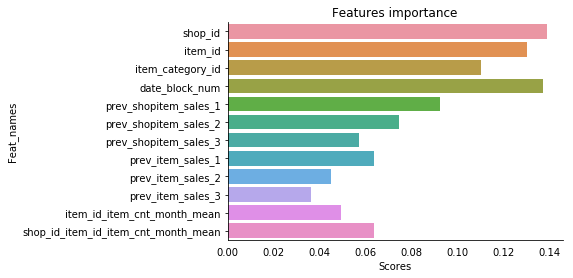

In [31]:
importance=pd.DataFrame(baseline_features[:-1], columns=["Feat_names"])
importance["Scores"]=model.feature_importances_
sns.barplot(data=importance, y="Feat_names", x="Scores", orient="h" )
plt.title("Features importance")
plt.tick_params(top='off', bottom='off', left='on', right='off', labelleft='on', labelbottom='on')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color("black")

## Select Features 

In [17]:
from sklearn.feature_selection import SelectFromModel
from numpy import sort

In [44]:
%%time
thresholds = sort(lgbm_model.feature_importances_)
for thresh in thresholds:
# select features using threshold
    selection = SelectFromModel(lgbm_model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(trainx)
    # train model
    selection_model = lgbm.LGBMModel(objective="regression")
    selection_model.fit(select_X_train, trainy, eval_metric='rmse')
    # eval model
    select_X_test = selection.transform(valx)
    predictions =selection_model.predict(select_X_test)
    rmse = sqrt(mean_squared_error(valy, predictions))
    print("Thresh=%.3f, n=%d, RMSE: %.4f%%" % (thresh, select_X_train.shape[1], rmse))
  

Thresh=104.000, n=12, RMSE: 0.9384%
Thresh=111.000, n=11, RMSE: 0.9479%
Thresh=124.000, n=10, RMSE: 0.9425%
Thresh=133.000, n=9, RMSE: 0.9443%
Thresh=159.000, n=8, RMSE: 0.9460%
Thresh=245.000, n=7, RMSE: 0.9334%
Thresh=251.000, n=6, RMSE: 0.9364%
Thresh=301.000, n=5, RMSE: 0.9479%
Thresh=316.000, n=4, RMSE: 0.9693%
Thresh=337.000, n=3, RMSE: 0.9804%
Thresh=344.000, n=2, RMSE: 0.9872%
Thresh=575.000, n=1, RMSE: 1.0803%
Wall time: 3min 41s


In [40]:
import lightgbm as lgbm

lgbm_model=lgbm.LGBMModel(objective="regression")
lgbm_model.fit(trainx, trainy, eval_metric="mse")

LGBMModel(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
     learning_rate=0.1, max_depth=-1, min_child_samples=20,
     min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
     n_jobs=-1, num_leaves=31, objective='regression', random_state=None,
     reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
     subsample_for_bin=200000, subsample_freq=0)

In [47]:
predictions=lgbm_model.predict(valx)

In [48]:
sqrt(mean_squared_error(valy, predictions))

0.9383720098995829

In [49]:
preds = lgbm_model.predict(testx)
    # Clipping to range 0-20
preds = np.clip(preds, 0,20)
#preds=[round(i,0) for i in preds]
df = pd.DataFrame(preds, columns = ['item_cnt_month'])
df['ID'] = df.index
df = df.set_index('ID')
df.to_csv('test_preds.csv')

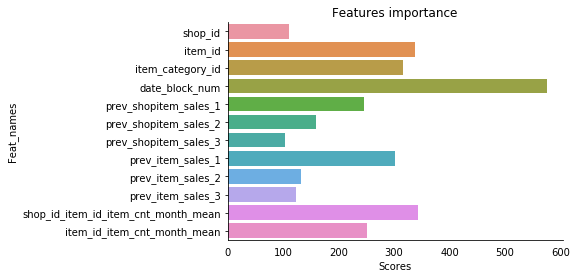

In [43]:

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

importance=pd.DataFrame(baseline_features[:-1], columns=["Feat_names"])
importance["Scores"]=lgbm_model.feature_importances_
sns.barplot(data=importance, y="Feat_names", x="Scores", orient="h" )
plt.title("Features importance")
plt.tick_params(top='off', bottom='off', left='on', right='off', labelleft='on', labelbottom='on')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color("black")

In [58]:
from catboost import CatBoostRegressor
# Initialize data

# Initialize CatBoostRegressor
model_cat = CatBoostRegressor(iterations=300, learning_rate=0.5, depth=7)
# Fit model
model_cat.fit(trainx, trainy)
# Get predictions
preds_cat = model_cat.predict(valx)
sqrt(mean_squared_error(valy, preds_cat))

0:	learn: 1.0142883	total: 1.15s	remaining: 5m 45s
1:	learn: 0.9146384	total: 2.27s	remaining: 5m 38s
2:	learn: 0.8770911	total: 3.36s	remaining: 5m 32s
3:	learn: 0.8630255	total: 4.44s	remaining: 5m 28s
4:	learn: 0.8553028	total: 5.53s	remaining: 5m 26s
5:	learn: 0.8511443	total: 6.62s	remaining: 5m 24s
6:	learn: 0.8485206	total: 7.67s	remaining: 5m 20s
7:	learn: 0.8466113	total: 9.03s	remaining: 5m 29s
8:	learn: 0.8435690	total: 10.1s	remaining: 5m 27s
9:	learn: 0.8406457	total: 11.4s	remaining: 5m 29s
10:	learn: 0.8391230	total: 12.4s	remaining: 5m 24s
11:	learn: 0.8378738	total: 13.6s	remaining: 5m 25s
12:	learn: 0.8359660	total: 14.7s	remaining: 5m 24s
13:	learn: 0.8352904	total: 15.7s	remaining: 5m 20s
14:	learn: 0.8329870	total: 16.8s	remaining: 5m 19s
15:	learn: 0.8315909	total: 17.9s	remaining: 5m 18s
16:	learn: 0.8299230	total: 19.1s	remaining: 5m 18s
17:	learn: 0.8285939	total: 20.2s	remaining: 5m 16s
18:	learn: 0.8278271	total: 21.3s	remaining: 5m 14s
19:	learn: 0.8262797	t

157:	learn: 0.7778371	total: 2m 54s	remaining: 2m 36s
158:	learn: 0.7771933	total: 2m 55s	remaining: 2m 35s
159:	learn: 0.7771248	total: 2m 56s	remaining: 2m 34s
160:	learn: 0.7766970	total: 2m 57s	remaining: 2m 32s
161:	learn: 0.7764804	total: 2m 58s	remaining: 2m 31s
162:	learn: 0.7763784	total: 2m 59s	remaining: 2m 30s
163:	learn: 0.7759684	total: 3m	remaining: 2m 29s
164:	learn: 0.7758560	total: 3m	remaining: 2m 28s
165:	learn: 0.7756428	total: 3m 1s	remaining: 2m 26s
166:	learn: 0.7755211	total: 3m 2s	remaining: 2m 25s
167:	learn: 0.7751115	total: 3m 4s	remaining: 2m 24s
168:	learn: 0.7750766	total: 3m 4s	remaining: 2m 23s
169:	learn: 0.7747945	total: 3m 5s	remaining: 2m 22s
170:	learn: 0.7745262	total: 3m 6s	remaining: 2m 20s
171:	learn: 0.7744689	total: 3m 7s	remaining: 2m 19s
172:	learn: 0.7744317	total: 3m 8s	remaining: 2m 18s
173:	learn: 0.7742986	total: 3m 9s	remaining: 2m 17s
174:	learn: 0.7742144	total: 3m 10s	remaining: 2m 16s
175:	learn: 0.7740844	total: 3m 11s	remaining

1.013423531370564